In [1]:
import sys
import cuentitas
# from entornomaximo import entornoMaximo as em
# from auxiliares import integracionGauss as ig
# from auxiliares import medicion
# from auxiliares import sigma
# from auxiliares import sigmaEmi
# from auxiliares import S0VV_completo
from auxiliares import generadorFran1Capa  #generador, generador1E, generadorEmisividad, 

from numpy import pi, sqrt, sin, cos, exp, log10, array, real, conj
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy import interpolate
import seaborn as sns
import pandas as pd
import glob
import theano.tensor as TT
import random

import time

import pymc3 as pm

sns.set() #seaborn como default

# m = 51 #valores que siempre uso
# X,Y,Wt = ig(m-1)

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
def toFitFran(ep, s, l, anguloR, landa): #Me devuelve un tensor de nn+mm, con nn valores de angulos s0 y mm emis
#     landa = 0.025
#     k0 = 2*np.pi/landa
#     phi = np.pi
    
#     ### s0
#     phs = phi + np.pi
#     thi = anguloR  #cambiar segun la zona
#     thi = thi*np.pi/180 #DU2 T008, T061, T021
#     ths = thi
#     k1 = k0*(sin(ths)*cos(phs)-sin(thi)*cos(phi))
#     k2 = k0*(sin(ths)*sin(phs)-sin(thi)*sin(phi))
 
#     aux = 4*np.pi*k0**2*cos(ths)**2*(abs(cuentitas.a1VVF1(k0,thi,phi,ths,phs,ep1,ep2,d))**2*cuentitas.w(s1,l1,k1,k2)+\
#             abs(cuentitas.a1VVF2(k0,thi,phi,ths,phs,ep1,ep2,d))**2*cuentitas.w(s2,l2,k1,k2)+\
#             2*real(cuentitas.a1VVF1(k0,thi,phi,ths,phs,ep1,ep2,d)*conj(cuentitas.a1VVF2(k0,thi,phi,ths,phs,ep1,ep2,d)))*cuentitas.w_f1f2(s1,l1,s2,l2,k1,k2))
#     s0s = 10*np.log10(aux)

    
    
#     ### Emisividad
#     thiEm = anguloWR*np.pi/180

#     ths_ = (X+1)*np.pi/4
#     phs_ = (Y+1)*np.pi
    
#     ths_1 = np.reshape(ths_, (1,m**2))
#     phs_1 = np.reshape(phs_, (1,m**2))
    
#     emi = []
#     for tt in thiEm:
#         q = (np.sin(ths_1)*S0VV_completo(k0,tt,phi,ths_1,phs_1,ep1,ep2,d,s1,l1,s2,l2))
#         aux = Wt*q
#         I_gauss = (np.pi**2/4)*aux.sum()
 
#         emi.append(1 - (I_gauss/(4*np.pi)))
    
#     ###

    

#     nn = len(anguloR)
#     mm = len(anguloWR)
#     pp = nn+mm

#     a = TT.zeros(pp)
#     for i in range(nn):
#         a = TT.set_subtensor(a[i], s0s[i])
    
#     for j in range(mm):
#         a = TT.set_subtensor(a[nn+j], emi[j])
#     print(incAng)
#     print(landa)
#     s0s = generadorFran(ep1,ep2,d,s1,l1,s2,l2,incAng,landa)
    s0s = generadorFran1Capa(ep, s, l, incAng, landa)
    
    pp = len(s0s[1])
    
    a = TT.zeros(pp)
#     print(s0s[1][0])
    for i in range(pp):
        a = TT.set_subtensor(a[i], s0s[1][i])
    
    
    return a


#     ###
#     nn = len(anguloR)
#     mm = len(anguloWR)
#     pp = nn+mm

#     a = TT.zeros(pp)
#     for i in range(nn):
#         a = TT.set_subtensor(a[i], s0s[i])

In [3]:
# angWR es el angulo sin ruido para simulaciones con emisividad, es indistinto el valor 
# que tome si uso la f() sin emisividad
def modelo(sector, angWR, landa, samples, sigmas): 
 
    phi = np.pi
    
    print(sector[1])
    print(sector[1].shape)

    
    ranges = {}
    ranges['ep'] = 1.4, 8
#     ranges['ep2'] = 1.4, 8
#     ranges['d'] = 0.001, 0.5
    ranges['s'] = 0.0001, 0.004
    ranges['l'] = 0.001, 0.04

    with pm.Model() as model:
        ep = pm.Uniform('ep', ranges['ep'][0], ranges['ep'][1])
#         ep2 = pm.Uniform('ep2', ranges['ep2'][0], ranges['ep2'][1])
#         d = pm.Uniform('d', ranges['d'][0], ranges['d'][1])
        s = pm.Uniform('s', ranges['s'][0], ranges['s'][1])
        l = pm.Uniform('l', ranges['l'][0], ranges['l'][1])

    def f(ep = ep,
          s = s,
          l = l):
#         return toFitEmis(ep1,ep2,d,s1,0.015,s2,0.01,angWR,sector[0])
            #toFitFran(ep1,ep2,d,s1,l1,s2,l2,anguloR)
#         return toFitFran(ep1,ep2,d,s1,0.015,s2,0.01,sector[0],landa)
        return toFitFran(ep, s, l, sector[0], landa)
    
    with model:
        function_pm = pm.Deterministic('s0f', f())
        observations = pm.Normal( "obs",  mu=real(function_pm), sigma=sigmas, observed=sector[1])
        trace = pm.sample_smc(samples, cores=4, parallel=True)  
    
    return trace

In [ ]:
# 'se' son los valores reales del modelo, 1 s0 para cada angulo y si es generador1E da 1 emisividad en nadir
# o si es generadorEmisividad da la misma cantidad de emisividades evaluado en cada thi
# 'seR' son los valores de s0 perturbados segun noiseSTD, estos estan en la cantidad de antes pero 
# multiplicados por 'n', en cuanto a la emisividad aparecen las mismas cantidades que antes

# C = 3 #cantidad de angulos iniciales
# [ang,se] = generador1E(C) #genera una emisividad global


# #[ang,se] = generadorEmisividad(C) #genera una emisividad para cada angulo
# val = se[:len(ang)]
# emi = se[len(ang):]

# val = np.reshape(val,(len(val),1))
# n = 1 #cantidad de "perturbaciones" de cada angulo

# noiseSTD = 0.1
# valRui = np.kron(val,np.ones((n,1))) + noiseSTD*np.random.randn(n*len(val),1)

# angR = np.reshape(ang,(len(ang),1))
# angR = np.kron(angR,np.ones((n,1)))

# angR = np.reshape(angR, (len(angR)))
# valR = np.reshape(valRui, (len(valRui)))

# emi = np.reshape(emi,(len(emi),1))
# emiRui = emi + 0.01*np.random.randn(len(emi),1)
# emiR = np.reshape(emiRui,(len(emi)))

# seR = np.concatenate((valR,emiR))




In [29]:
# incAng = [15,20,25,35,45]
# landa = [0.025]

incAng = [15,20,25]
# incAng = [20]
landa = [0.025]
# landa = [0.025,0.05]


# incAng = [20]
# surfaceModelParam = [1.93,5,0.05,0.0017,0.015,0.003,0.01]
# surfaceModelParam = [1.93,
#                      5.0,
#                      0.3,
#                      0.001,
#                      0.01,
#                      0.002,
#                      0.01] #set1
# surfaceModelParam = [1.93,5,0.05,0.0017,0.015,0.003,0.01] #set2


ep_ = 1.93
s_ = 0.001
l_ = 0.01 #set1


# generadorFran(1.93,
#                   5.0,
#                      0.3,
#                      0.001,
#                      0.01,
#                      0.002,
#                      0.01,
#               incAng,
#              landa)
# ep_ = 4
# s_ = 0.001
# l_ = 0.01 #set2


generadorFran1Capa(ep_, s_, l_, incAng, landa)

array([array([15, 20, 25]),
       array([-15.41650973, -16.69023837, -18.28056941,   0.99759967])],
      dtype=object)

In [30]:
qw = toFitFran(ep_, s_, l_, incAng, landa)

In [31]:
qw.eval() #parece que así evalúa el tensor

array([-15.41650973, -16.69023837, -18.28056941,   0.99759967])

In [18]:
# qq[1].shape

In [19]:
# np.asarray(len(incAng)*len(landa)*[0.1] + len(landa)*[0.01])

In [32]:
# m = 51
# X,Y,Wt = ig(m-1)

muestras = 20000
# Nombre = 'Delta'

#------------ error para generador1E() ------------#
#sig = np.asarray(len(angR)*[noiseSTD**2] + [0.05])

# sig = np.asarray(len(angR)*[0.1] + [0.01]) #original Javi

# sig = np.asarray(len(incAng)*[0.1] + [0.01])  #pruebas error

# sig = np.asarray(len(incAng)*len(landa)*[0.1] + len(landa)*[0.01]) #the posta post

sig = np.asarray(len(incAng)*len(landa)*[0.1] + len(landa)*[0.01])


# sig = np.asarray(len(incAng)*[0.1])  #pruebas error

traza = modelo(generadorFran1Capa(ep_, s_, l_, incAng, landa),
                              np.asarray([0.0001]),
                              landa,
                              muestras,
                              sig)
 
#------------ error para generadorEmisividad()) ------------#
# sig = np.asarray(len(angR)*[noiseSTD**2] + len(ang)*[0.001])
# traza = modelo([angR,seR],ang,muestras,sig)

[-15.41650973 -16.69023837 -18.28056941   0.99759967]
(4,)


Initializing SMC sampler...
Sampling 4 chains in 4 jobs
WARNING (theano.tensor.opt): Optimization Warning: The Op exp does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op exp does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op exp does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op exp does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op real does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op real does not provide a C implementation. As well as be

In [33]:
plotear = np.stack((traza['ep'], traza['s'], traza['l'])).T
dfplotear = pd.DataFrame(plotear, columns = ['ep','s','l'])

In [34]:
# modelIn = [1.93,5,0.05,0.0017,0.015,0.003,0.01]
# modelInReduced = [surfaceModelParam[0], 
#                   surfaceModelParam[1],
#                   surfaceModelParam[2],
#                   surfaceModelParam[3],
#                   surfaceModelParam[5]]

modelInReduced = [ep_, s_, l_]

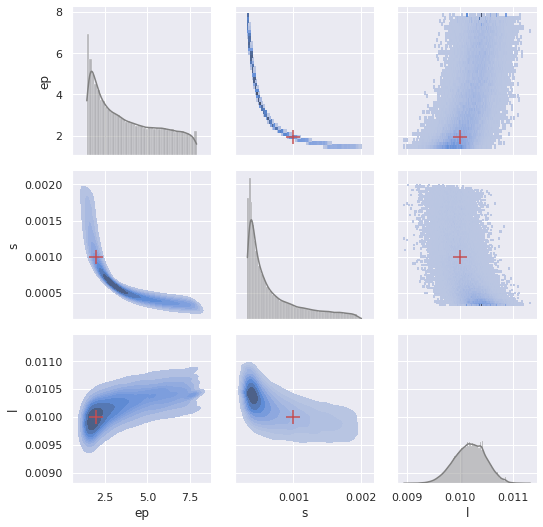

In [35]:
f = sns.PairGrid(dfplotear)
# f.fig.suptitle(Nombre, y=1.01, fontsize = 'large')
f.map_upper(sns.histplot)

f.map_lower(sns.kdeplot, fill=True)
f.map_diag(sns.histplot, kde=True, color='.5')

for i in range(3):
    for j in range(3):
        if i == j:
            #ploteo el valor verdadero en las marginales
#             f.axes[j,i].axvline(modelInReduced[i], color='r', linestyle='dashed', linewidth=1)
            pass
        else:
            f.axes[j,i].scatter(modelInReduced[i], modelInReduced[j], marker="+", c='r', s=200) #color='k', linestyle='dashed', linewidth=1)
            
            
#         f.axes[j,i].xaxis.set_label_text(xlabels[i])
#         f.axes[j,i].yaxis.set_label_text(ylabels[j])
#         f.axes[j,i].xaxis.set_label_text(xlabels[i])
#         f.axes[j,i].scatter(1,1)




In [36]:
nombre = "set1-1Capa-noNoise-3s0+1emi-20000"
f.savefig('Resultados/'+nombre+'.png', dpi=300)

In [37]:
e_ = traza['ep']
# e2 = traza['ep2']
# d = traza['d']
s_ = traza['s']
l_ = traza['l']

guardar = [e_,s_,l_]



f_ = np.savetxt('Resultados/'+nombre+'Trazas.txt', guardar, delimiter=';')
f2_ = np.savetxt('Resultados/'+nombre+'Trazas-input.txt', np.asarray([np.asarray(incAng),np.asarray(modelInReduced)],dtype=object), fmt='%s', delimiter=';')
